다음의 캐글 노트북을 필사했습니다.

https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

## Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

## Load the data

In [3]:
trainset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Porto Seguro’s Safe Driver Prediction/data/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Porto Seguro’s Safe Driver Prediction/data/test.csv')

## Few quick observations

대회의 data description을 기초로 몇 가지 빠른 관측을 할 수 있습니다.  
  
* 소수의 그룹이 정의됐으며 이러한 그룹에 속한 피처들은 이름에 패턴이 포함됐습니다.(ind, reg, car, calc). **ind**는 아마도 **individual**일 것이며 **reg**는 아마 **registration**, **car**는 스스로 설명되며 **calc**는 **calculatted** field를 암시할 것입니다.  
* 접두사 **bin**은 binary features로 쓰였을 것입니다.  
* 접두사 **cat**은 categorical feature로 사용됐을 것입니다.  
* **bin**과 **cat**표시가 없는 피처는 정수의(순서형 변수)의 실수(연속형 변수)입니다.  
* 결측치는 -1로 나타납니다.  
* 예측의 주가 되는 값은 **target** 컬럼에 있습니다. 이는 보험을 든 사람이 청구(claim) 했는지의 여부를 나타냅니다.  
* **id**는 input 순서형 번호입니다.  
  
위와 같은 해석이 맞는지 확인해 봅시다.

In [4]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


실제로 **cat** 값은 **categorical**이며, integer 값은 0부터 n까지의 값을 가집니다. **bin** 값은 **binary**입니다. (0 또는 1)

얼마나 많은 행과 컬럼이 있는지 살펴봅니다.

In [5]:
print("Train dataset (rows, cols):", trainset.shape, "\n Test dataset (rows, cols):", testset.shape)

Train dataset (rows, cols): (595212, 59) 
 Test dataset (rows, cols): (892816, 58)


**target**이 train에 포함됐기 때문에 train과 test 컬럼의 개수 차이는 1입니다. 구체적으로 확인해 봅시다.

In [6]:
print("Columns in train and not in test dataset:", set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset: {'target'}


## Introduction of metadata

데이터에 대한 조작을 쉽게 하기 위해서 trainset에 있는 변수에 몇가지 meta 정보를 연동시킬 것입니다. 이는 분석이나 추론, 모델링을 위해 피처의 변수 종류 선택을 수행할 것입니다. 우리는 피처의 type에 따라 이러한 category field를 사용하고 있습니다. `car`, `ind`, `reg`, `calc`  
  
metadata가 쓰일 것들:  
* **use**: input, ID, target
* **type**: nominal, interval, ordinal, binary
* **preserve**: True of False
* **dataType**: int, float, char
* **category**: ind, reg, car, calc

In [7]:
data = []
for feature in trainset.columns:
  # Defining the role
  if feature == 'target':
    use = 'target'
  elif feature == 'id':
    use = 'id'
  else:
    use = 'input'

  # Defining the type
  if 'bin' in feature or feature == 'target':
    type = 'binary'
  elif 'cat' in feature or feature == 'id':
    type = 'categorical'
  elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
    type = 'real'
  elif trainset[feature].dtype == int:
    type = 'integer'

  
  # Initialize preserve to True for all variables except for id
  preserve = True
  if feature == 'id':
    preserve = False

  # Defining the data type
  dtype = trainset[feature].dtype

  category = 'none'
  # Defining the category
  if 'ind' in feature:
    category = 'individual'
  elif 'reg' in feature:
    category = 'registration'
  elif 'car' in feature:
    category = 'car'
  elif 'calc' in feature:
    category = 'calculated'

  # Creating a Dict that contains all the metadata for the variable
  feature_dictionary = {
      'varname': feature,
      'use': use,
      'type': type,
      'preserve': preserve,
      'dtype': dtype,
      'category': category
  }
  
  data.append(feature_dictionary)

In [8]:
data[:2]

[{'category': 'none',
  'dtype': dtype('int64'),
  'preserve': False,
  'type': 'categorical',
  'use': 'id',
  'varname': 'id'},
 {'category': 'none',
  'dtype': dtype('int64'),
  'preserve': True,
  'type': 'binary',
  'use': 'target',
  'varname': 'target'}]

In [9]:
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


예를 들어 모든 범주형 변수를 뽑아보겠습니다.

In [10]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 피처를 살펴 보고 얼마나 많은 특징적인 범주형 값이 있는지 봅시다.

In [11]:
metadata.groupby(['category'])['category'].size()

category
calculated      20
car             16
individual      18
none             2
registration     3
Name: category, dtype: int64

In [12]:
metadata.groupby(['category']).size()

category
calculated      20
car             16
individual      18
none             2
registration     3
dtype: int64

In [13]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


20개의 calculated 피처, 16개의 car, 18개의 individual, 그리고 3개의 registration이 있습니다.  
  
모든 변수를 살펴 보고 고유한 값에 대해 얼마나 많은 use와 type이 있는지 알아봅시다.

In [14]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


하나의 명목 변수(id), 20개의 이진 값, 21개의 정수(혹은 소수), 16개의 범주형 피처가 있습니다. -이들은 모두 **input** 값입니다. 하나의 **target** 값이 있는데, 이는 binary이며 target입니다.

## Data analysis and statistics

### Target variable

In [15]:
x = trainset['target'].value_counts().index
x

Int64Index([0, 1], dtype='int64')

In [16]:
x = trainset['target'].value_counts().index.values
x

array([0, 1])

In [17]:
trainset['target'].value_counts().values

array([573518,  21694])

<Figure size 432x288 with 0 Axes>

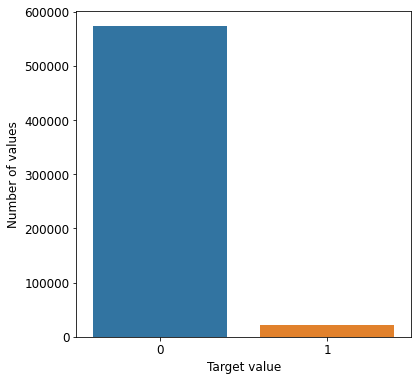

In [18]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

오직 3.64%의 타겟 데이터가 1을 가지고 있습니다. 이는 트레이닝 데이터셋이 매우 불균형하다는 것을 의미합니다. 우리는 target=0으로 undersample을 하거나 target=1으로 oversample을 할 수 있습니다. 데이터셋이 크기 때문에 terget=0을 기준으로 undersampling을 하겠습니다.

### Rea feature

In [19]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [20]:
pow(2, 3)

8

In [21]:
trainset['ps_car_12'].head(5)

0    0.400000
1    0.316228
2    0.316228
3    0.374166
4    0.316070
Name: ps_car_12, dtype: float64

In [22]:
(0.316228*10)**2

10.0000147984

In [23]:
(pow(trainset['ps_car_12']*10, 2)).head(10) # 10을 곱한 뒤 제곱을 해줌

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [24]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

**Feature with missing values**  
`ps_reg03`, `pd_car_12`, `ps_car_14`는 결측치를 가지고 있습니다. (최소값이 -1)

**Registration features**  
`ps_reg_01`, `ps_reg_02`는 분모가 10인 분수입니다. (0.1, 0.2, 0.3과 같은 것들)

**Car features**  
`ps_car_12`는 (근사했을 때) 자연수의 제곱근이며 `ps_car_15` 또한 자연수의 제곱근입니다. pair plot을 이용해 값들을 살펴봅시다.

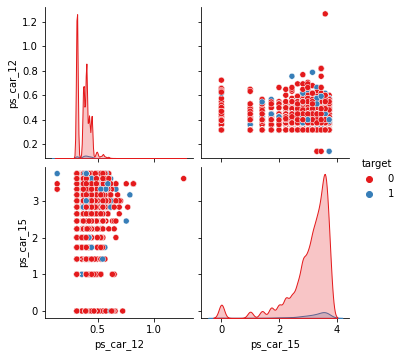

In [29]:
sample = trainset.sample(frac=0.05) # 0.05의 비율을 취함
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

**Calculated features**  
`ps_calc_01`, `ps_calc_02`, `pc_calc_03`은 매우 비슷한 분포를 띄며 어떤 비율인 듯 합니다. 왜냐하면 이들 모두 최대값이 0.9이기 때문입니다. 다른 calculated 값은 최대값이 정수입니다. (5, 6, 7, 10, 12)

실수 피처의 분포를 density plot을 이용해 시각화 해봅시다.

In [32]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
len(var)

10

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

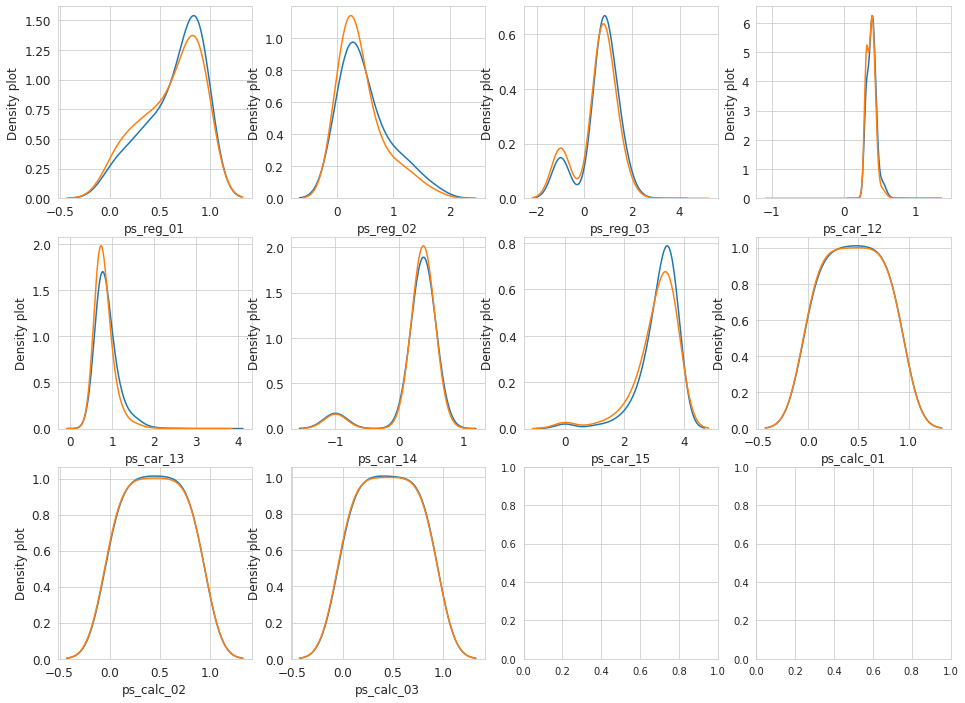

In [37]:
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
  i += 1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
  sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

`ps_reg_02`, `ps_car_13`, `ps_car_15`는 제일 다른 분포를 보여줍니다. target=0, target=1과 연관된 값의 집합들 사이에서

실수 피처들 간의 상관관계를 시각화해 봅시다.

In [41]:
def corr_heatmap(var):
  correlations = trainset[var].corr()

  # Create color map ranging between two colors
  cmap = sns.diverging_palette(50, 10, as_cmap=True)

  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True,
                    linewidths=.5, annot=True, cbar_kws={"shrink": .75})
  plt.show();

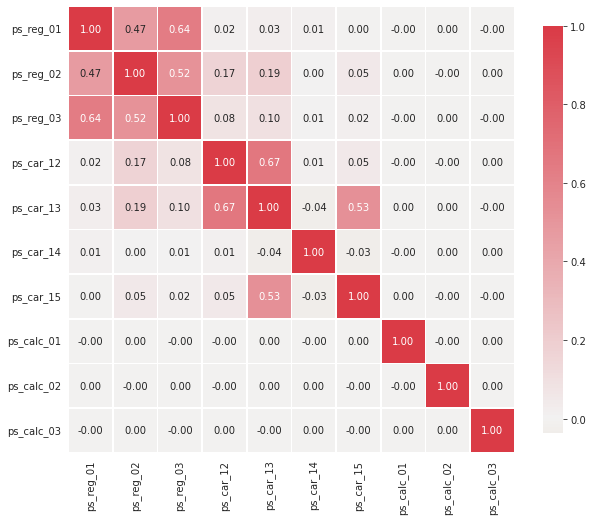

In [42]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

상관관계가 강한 변수들입니다. 이들을 시각화합시다.
* ps_reg_01 with ps_reg_02 (0.47);
* ps_reg_01 with ps_reg_03 (0.64);
* ps_reg_02 with ps_reg_03 (0.52);
* ps_car_12 with ps_car_13 (0.67);
* ps_car_13 with ps_car_15 (0.53);  
상관관계가 있는 값들의 쌍을 보여주기 위해 pairplot을 쓸 것입니다. pairs를 시각화하기 전에 sample의 2%를 사용해 subsample을 합니다.

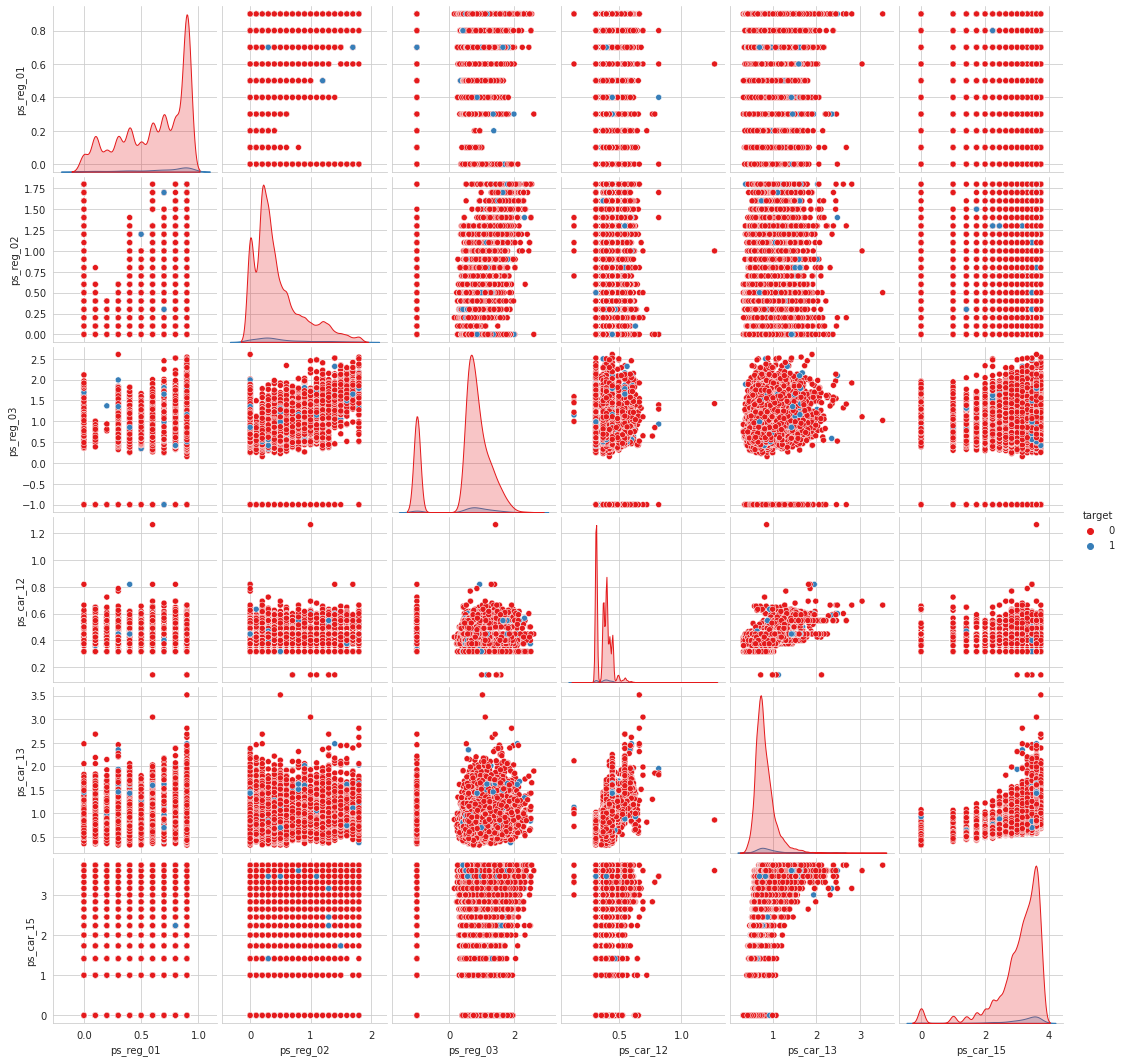

In [44]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]

sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Binary features

In [45]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
